# Asset Management

## Question I.

Robust Global Minimum Variance Portfolio

Construct, back-test and evaluate a robust MV portfolio, built using a shrinkage estimator of the covariance matrix. Import the dataset "ind30 m vw rets.csv" of value-weighted 30 industry portfolios and use data from 1980.

1. Define a function called weight gmv shrink, which returns the weights on a global minimum variance portfolio built using a covariance matrix.

2. Bar plot the weights of the equally weighed portfolio and the weights of the R-GMV portfolio,
and interpret the results.

3. Define a backtest function to back test the equally weighted portfolio together with the R-
GMV portfolio. Use estimation windows of 12months, 60months and 120months. Interpret the results.

In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_ff30_returns():
    ff30 = pd.read_csv("ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ff30.index = pd.to_datetime(ff30.index, format="%Y%m").to_period('M')
    ff30.columns = ff30.columns.str.strip()
    return ff30

ff30 =  get_ff30_returns()
ff30_1980 = ff30["1980":]
ff30_1980.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1980-01,0.0301,0.1104,-0.0063,0.0658,0.0415,0.0128,0.0112,-0.0129,0.0432,0.0514,...,-0.0205,0.0709,0.0729,0.0463,0.0956,0.0543,-0.0043,0.0300,0.0207,0.0779
1980-02,-0.0576,-0.0230,-0.0480,-0.0353,-0.0623,-0.0468,-0.0051,-0.0463,-0.0132,-0.0114,...,-0.0148,-0.0306,-0.0355,-0.0026,-0.0446,-0.0250,-0.0542,-0.0586,-0.0498,-0.0235
1980-03,-0.0824,-0.1343,-0.0071,-0.0874,-0.1195,-0.0444,-0.0543,-0.0284,-0.1199,-0.1453,...,-0.0264,-0.1538,-0.1267,-0.1083,-0.1399,-0.0985,-0.0783,-0.1295,-0.0883,-0.1581
1980-04,0.0746,0.0431,0.0957,0.0419,0.0308,0.0430,0.0239,0.0428,0.0502,0.0574,...,0.0730,0.0858,0.0054,0.0401,0.0034,-0.0174,0.0465,0.0785,0.0681,0.0733
1980-05,0.0786,0.0976,0.0895,0.0468,0.0964,0.0641,0.0145,0.0696,0.0758,0.0759,...,0.0502,0.0806,0.0480,0.0658,0.1140,0.1228,0.0955,0.1205,0.0781,0.0742


In [3]:
from scipy.optimize import minimize

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns r
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def get_rf():
    """
    import the time series of the risk-free rate
    """
    rf = pd.read_excel("rf.xlsx", header=0, index_col=0)
    rf.index = pd.to_datetime(rf.index, format="%Y%m").to_period('M')
    rf.columns = rf.columns.str.strip()
    return rf

def weight_ew(r,rf):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def weight_msr (r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    er=r.mean()
    cov=r.cov()
    rff= rf.rf.values.mean()
    return pd.Series(msr(rff, er, cov), index=r.columns)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    cov= sample_cov(r)
    return pd.Series(gmv(cov), index=r.columns)

def weight_gmv_cc(r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    cov=cc_cov(r)
    return pd.Series(gmv(cov), index=r.columns)

def backtest_ws(r, rf, estimation_window=60, weighting=weight_msr):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]], rf.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def weight_cw(r, rf):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    #nfirms = get_ff30_nfirms()
    #size = get_ff30_size()
    #mkt_cap = nfirms * size
    #total_mkt_cap = mkt_cap.sum(axis=1)
    #cap_weight = mkt_cap.divide(total_mkt_cap, axis="index")
    return cap_weight.loc[r.index[1]]

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def weight_gmv(r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    cov= r.cov(r)
    return pd.Series(gmv(cov), index=r.columns)

def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

def shrinkage_cov(r, delta=0.5, **kwargs):##Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

In [4]:
def weight_gmv_shrink(r, delta=0.5, **kwargs):
    n = len(r.columns)
    cov=shrinkage_cov(r)
    return pd.Series(gmv(cov), index=r.columns)

weight_gmv_shrink(ff30_1980)

Food     2.022872e-01
Beer     5.425414e-04
Smoke    7.378617e-13
Games    5.390155e-13
Books    0.000000e+00
Hshld    1.885808e-01
Clths    0.000000e+00
Hlth     8.306223e-02
Chems    0.000000e+00
Txtls    1.281580e-12
Cnstr    4.823388e-13
Steel    1.247737e-12
FabPr    5.755868e-14
ElcEq    3.996551e-13
Autos    7.705368e-13
Carry    1.473576e-13
Mines    3.571178e-13
Coal     3.980509e-12
Oil      0.000000e+00
Util     4.531945e-01
Telcm    6.630726e-02
Servs    0.000000e+00
BusEq    0.000000e+00
Paper    0.000000e+00
Trans    0.000000e+00
Whlsl    0.000000e+00
Rtail    0.000000e+00
Meals    6.025478e-03
Fin      0.000000e+00
Other    0.000000e+00
dtype: float64

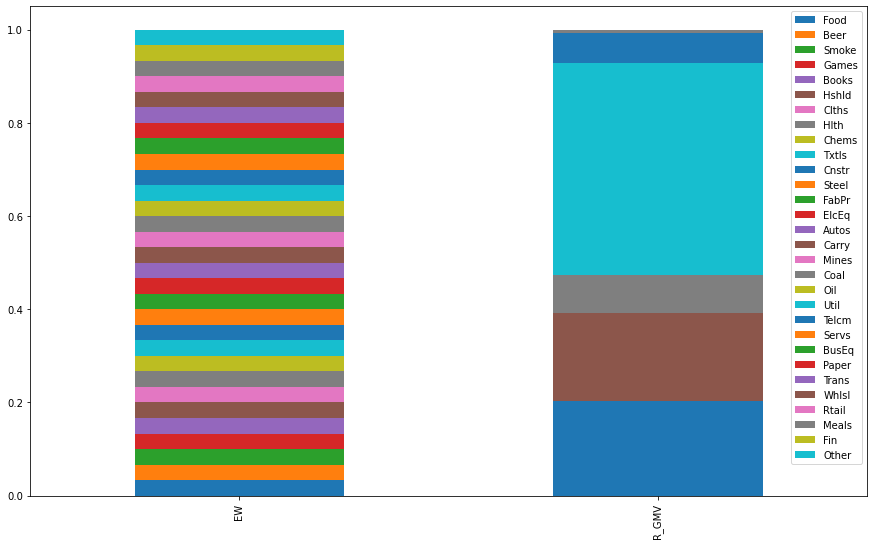

In [5]:
wts = pd.DataFrame({
    "EW": weight_ew(ff30_1980, get_rf()),
    "R_GMV": weight_gmv_shrink(ff30_1980,  get_rf()) })

wts.T.plot.bar(stacked=True, figsize=(15,9), legend=True);

In [6]:
wts["R_GMV"].sort_values(ascending=False).head(7) # just to check industry weights

Util     0.453195
Food     0.202287
Hshld    0.188581
Hlth     0.083062
Telcm    0.066307
Meals    0.006025
Beer     0.000543
Name: R_GMV, dtype: float64

The Equally weighted plot bears no suprises: every one of the 30 industries has the same weight in the portfolio (3.33%). 
    
Regarding the Robust Global Minimum Variance portfolio, the standout industry is utilities, with approximately 45% of the total weight of the portfolio.       

After utilities, and very close to each other in terms of portfolio weights, are the food and household insdustries with 20% and 19% respectively.  

The health industry and the telecomunications industry, with 8% and 7% respectively, are also easy to spot on the plot.

The remaining industries in the R_GMV portfolio have such low weights (<1%) that are impossible to distinguish in the plot bar.

Ultimately, to obtain a Rpbust Global Minimum Variance portfolio computed with a shrinkage estimator, we went from a portfolio with 30 industries, to one where the bolk of the portfolio weight is taken up by just 5 industries.

In [7]:
ew_ret12 = backtest_ws(ff30_1980, get_rf(), estimation_window=12, weighting= weight_ew)
ew_ret60 = backtest_ws(ff30_1980, get_rf(), estimation_window=60, weighting= weight_ew)
ew_ret120 = backtest_ws(ff30_1980, get_rf(), estimation_window=120, weighting= weight_ew)

r_gmv_ret12 = backtest_ws(ff30_1980, get_rf(), estimation_window=12, weighting= weight_gmv_shrink)
r_gmv_ret60 = backtest_ws(ff30_1980, get_rf(), estimation_window=60, weighting= weight_gmv_shrink)
r_gmv_ret120 = backtest_ws(ff30_1980, get_rf(), estimation_window=120, weighting= weight_gmv_shrink)

<AxesSubplot:title={'center':'EW & R-GMV Portfolios'}>

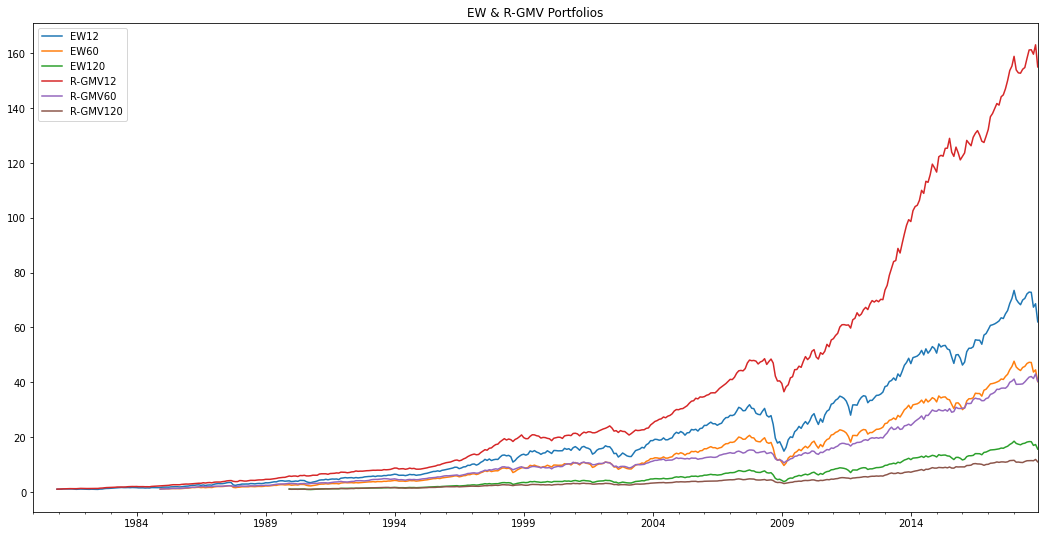

In [8]:
btr = pd.DataFrame({"EW12": ew_ret12,  "EW60": ew_ret60, "EW120": ew_ret120,
                    "R-GMV12": r_gmv_ret12, "R-GMV60": r_gmv_ret60, "R-GMV120": r_gmv_ret120 })

(1+btr).cumprod().plot(figsize=(18,9), title="EW & R-GMV Portfolios")

##### Interpretation:

From the plot above we can observe that best performing portfolio was the robust global minimum variance portfolio with an estimation windows of 12 months. In fact, the top 2 portfolios were the ones with the smallest estimation windows: R-GMV 12 months and EW 12 months.

At the bottom of the graph we see the robust global minimum variance portfolio with an estimation windows of 120 months. We easly conclude that the R-GMV portfolio has both the best performing and the worst performing portfolio.

Overall, we come to the conclusion that a bigger estimation windows leads to a worst performance in both portfolios, and a shorter estimation windows leads to a better performing porfolio. This is likely because our dataset contains noise that it is cleared out when we increase the estimation windows.

## Question II.

Performance analysis on the returns on the Berkshire Hathaway portfolio, using the CAPM and the FF3M model then as factor benchmarks.

Import the file "brka d ret.csv" of daily returns on the Berkshire Hathaway portfolio (convert
them to monthly returns) and import the Fama-French Research Factor Monthly Dataset "F-F Research Data Factors m.csv". Consider the time periods 1990−2003 and 2003−2018, as well as of the full sample 1990−2018.
For each of these three cases, compute α, σT E and its corresponding information ratio IR, relative
to the two benchmarks. Discuss and comment the results obtained.

In [4]:
brka_d = pd.read_csv("brka_d_ret.csv", parse_dates=True, index_col=0)

def compound(r):                                     
    return np.expm1(np.log1p(r).sum())

brka_m = brka_d.resample('M').apply(compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [5]:
def get_fff_returns():                                              
    rets = pd.read_csv("F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

fff = get_fff_returns()
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


#### The CAPM Benchmark

##### Period of 1990-2003

In [6]:
import statsmodels.api as sm

brka_excess90_03 = brka_m.loc["1990":"2002-12",['BRKA']] - fff.loc["1990":"2002-12", ['RF']].values
mkt_excess90_03 = fff.loc["1990":"2002-12",['Mkt-RF']]
exp_var90_03 = mkt_excess90_03.copy()
exp_var90_03["Constant"] = 1
lm90_03 = sm.OLS(brka_excess90_03, exp_var90_03).fit()

replicating_port90_03 = brka_m["1990": "2002-12"]['BRKA'].values - lm90_03.params[0]*(fff["1990":"2002-12"]['Mkt-RF'].values + fff["1990":"2002-12"]['RF'].values) -(1-lm90_03.params[0])*fff["1990":"2002-12"]['RF'].values

In [7]:
te90_03 = replicating_port90_03.std()
te_ann90_03 = te90_03*np.sqrt(12)

alpha90_03 = replicating_port90_03.mean()
alpha_ann90_03 = (1 + alpha90_03)**12 - 1

IR_ann90_03 = alpha_ann90_03 / te_ann90_03

##### Interpretation of results

In [13]:
print(lm90_03.summary())
print()
print("1990-2003 Annualized Alpha:", alpha_ann90_03)
print("1990-2003 Annualized Tracking Error:", te_ann90_03)
print("2003-2018 Annualized Information Ratio:", IR_ann90_03)

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     25.06
Date:                Fri, 13 May 2022   Prob (F-statistic):           1.50e-06
Time:                        20:54:45   Log-Likelihood:                 206.98
No. Observations:                 156   AIC:                            -410.0
Df Residuals:                     154   BIC:                            -403.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5734      0.115      5.006      0.0

The results imply that the CAPM benchmark consists of 57 cents in the market and 43 cents in T-bills. 
In terms of the alpha, the Berkshire Hataway is outpeforming the benchmark around 12% per year, which is quite an impressive feat. However, it is important to point out that when we look at the regression parameters, the degree of statistical significance is not very high.

The industry says that a benchmark is not considered inappropriate for performance analysis of a fund if its annualized tracking error is below 6%. In this case the annualized tracking error is around 22%, which suggests that the market is not appropriate, and that the fund may actually load on additional risk factors which would explain the relatively high alpha value obtained.

Regarding the information ratio, the annualized value for the period of 1990 to 2003 sits roughly at 0.54, which can be considered good. This means that the portfolio produced excess returns for a sufficiently long-time and that it turned out to be a good investment.

##### Period of 2003-2018

In [14]:
brka_excess03_18 = brka_m.loc["2003-01":"2018-12",['BRKA']] - fff.loc["2003-01":"2018-12", ['RF']].values
mkt_excess03_18 = fff.loc["2003-01":"2018-12",['Mkt-RF']]
exp_var03_18 = mkt_excess03_18.copy()
exp_var03_18["Constant"] = 1
lm03_18 = sm.OLS(brka_excess03_18, exp_var03_18).fit()

replicating_port03_18 = brka_m["2003-01":"2018-12"]['BRKA'].values - lm03_18.params[0]*(fff["2003-01":"2018-12"]['Mkt-RF'].values + fff["2003-01":"2018-12"]['RF'].values) -(1-lm03_18.params[0])*fff["2003-01":"2018-12"]['RF'].values

In [15]:
te03_18 = replicating_port03_18.std()
te_ann03_18 = te03_18*np.sqrt(12)

alpha03_18 = replicating_port03_18.mean()
alpha_ann03_18 = (1 + alpha03_18)**12 - 1

IR03_18 = alpha03_18/te03_18
IR_ann03_18 = ((1+alpha03_18)**12 - 1)/(te03_18*np.sqrt(12))

##### Interpretation of results

In [16]:
print(lm03_18.summary())
print()
print("2003-2018 Annualized Alpha:", alpha_ann03_18)
print("2003-2018 Annualized Tracking Error:", te_ann03_18)
print("2003-2018 Annualized Information Ratio:", IR_ann03_18) 

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     68.12
Date:                Fri, 13 May 2022   Prob (F-statistic):           2.54e-14
Time:                        20:54:46   Log-Likelihood:                 350.22
No. Observations:                 192   AIC:                            -696.4
Df Residuals:                     190   BIC:                            -689.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5873      0.071      8.253      0.0

The regression indicates that the value invested in the market from the period of 2003 to 2018 as increased from 57 cents to almost 59 cents (subsequently, the amount in T-bills as decreased to 41 cents). Our alpha sees a significant decrease, now siting at around 4% (but just like the previous period, this value is not statistical significant).

Another metric decreased is the tracking error, with an annualized value of 13.5%. This is still above the 6% threshold, and therefore is still considered a bad tracking error.

The information ratio also decreases to 0.29 which is substandard. It means that the portfolio could not produce excess returns for a sufficiently long-time and that it may not be a good investment.

Overall, this period performed poorly when compared to the time frame of 1990-2003. Although our tracking error decreased (which is a good thing because it means that the portfolio is more closely following the benchmark), the information error also saw a huge decrease, impliyng that the outperformance per unit of tracking error was lower.


##### Period 1990-2018

In [17]:
brka_excess90_18 = brka_m.loc["1990-01":"2018-12",['BRKA']] - fff.loc["1990-01":"2018-12", ['RF']].values
mkt_excess90_18 = fff.loc["1990-01":"2018-12",['Mkt-RF']]
exp_var90_18 = mkt_excess90_18.copy()
exp_var90_18["Constant"] = 1
lm90_18 = sm.OLS(brka_excess90_18, exp_var90_18).fit()

replicating_port90_18 = brka_m["1990-01":"2018-12"]['BRKA'].values - lm90_18.params[0]*(fff["1990-01":"2018-12"]['Mkt-RF'].values + fff["1990-01":"2018-12"]['RF'].values) -(1-lm90_18.params[0])*fff["1990-01":"2018-12"]['RF'].values

In [18]:
te90_18 = replicating_port90_18.std()
te_ann90_18 = te90_18*np.sqrt(12)

alpha90_18 = replicating_port90_18.mean()
alpha_ann90_18 = (1 + alpha90_18)**12 - 1

IR90_18 = alpha90_18/te90_18
IR_ann90_18 = ((1+alpha90_18)**12 - 1)/(te90_18*np.sqrt(12))

##### Interpretation of results

In [19]:
print(lm90_18.summary())
print()
print("1990-2018 Annualized Alpha:", alpha_ann90_18)
print("1990-2018 Annualized Tracking Error:", te_ann90_18)
print("1990-2018 Annualized Information Ratio:", IR_ann90_18)

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     76.69
Date:                Fri, 13 May 2022   Prob (F-statistic):           9.03e-17
Time:                        20:54:46   Log-Likelihood:                 535.44
No. Observations:                 348   AIC:                            -1067.
Df Residuals:                     346   BIC:                            -1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5779      0.066      8.757      0.0

In this period, the amount invested in the market is very close to the othe periods, being around 58 cents. The annualized alpha sees an increase when compared to the previous period, sitting at 7.5%.

The annualized tracking error also increases to 18% when compared to 2003-2018, meaning that the portfolio didn´t follow the benchmark as well.

Thankfully, the information ratio increases to 0.42. This is a considerable improvement from the previous period.

Final remarks:

In all of the 3 periods analyzed, but in particular in the periods of 1990-2003 and 1990-2018, the value of alpha is really good, with the investment consistently outperforming the benchmark. However, it is important to point out that when we look at the regression parameters, the degree of statistical significance wasn´t very high in any of the periods.

In terms of our tracking error, we obtain a high TE in all of the periods. This explains why our alpha values are so good: the reason for the over performance of the investment in relation to its benchmark was because of a higher risk exposure.

Regarding the information ratio, we see that the period between 2003-2018 was the period where the investment demonstrated lower levels of consistency when it comes beating its benchmark. In the other periods, the IR can be considered a good one if we go by the industry standards.

#### The Fama French Benchmark

##### Period 1990-2003

In [20]:
exp_var90_03["Value"] = fff.loc["1990":"2002-12",['HML']]
exp_var90_03["Size"] = fff.loc["1990":"2002-12",['SMB']]
lm_ff90_03 = sm.OLS(brka_excess90_03, exp_var90_03).fit()
replicating_port_ff90_03 = brka_m["1990": "2002-12"]['BRKA'].values - lm_ff90_03.params[0]*(fff["1990":"2002-12"]['Mkt-RF'].values + fff["1990":"2002-12"]['RF'].values) -(1-lm_ff90_03.params[0])*fff["1990":"2002-12"]['RF'].values -lm_ff90_03.params[2]*fff["1990":"2002-12"]['HML'].values-lm_ff90_03.params[3]*fff["1990":"2002-12"]['SMB'].values

alpha_ff90_03 = replicating_port_ff90_03.mean()
alpha_ann_ff90_03 = (1 + alpha_ff90_03)**12 - 1

te_ff90_03 = replicating_port_ff90_03.std()
te_ann_ff90_03 = te_ff90_03*np.sqrt(12)

IR_ann_ff90_03 = ((1+lm_ff90_03.params[1])**12-1)/te_ann_ff90_03

##### Interpretation of results

In [21]:
print(lm_ff90_03.summary())
print()
print("1990-2003 Annualized Alpha:", alpha_ann_ff90_03)
print("1990-2003 Annualized Tracking Error:", te_ann_ff90_03)
print("1990-2003 Annualized Information Error:", IR_ann_ff90_03)

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     24.65
Date:                Fri, 13 May 2022   Prob (F-statistic):           4.69e-13
Time:                        20:54:46   Log-Likelihood:                 226.15
No. Observations:                 156   AIC:                            -444.3
Df Residuals:                     152   BIC:                            -432.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8306      0.118      7.064      0.0

Comparing to the CAPM benchmark during the same period, the loading on the market has increase substantially: it went from 57 cents to 83 cents! In terms of the alpha, theres a decrease from 12% to 8.25%. From the regression we can deduct that adding variables has changed things around quite a bit. Adding value and size as variables has increased the total weight attributed to the market. 

The positive tilt on value suggests that the strategy of BRK is strongly tilted towards exploiting value stocks, whereas the negative tilt on size indicates that BRK mostly invests into large stocks compared to smaller ones. 

To summarize each dollar invested in BRK: 83 cents in the market, 17 cents in Bills, 51 cents in Value stocks, -51 cents in growth, 49 cents in large Cap stocks and minus 49 cents in small Cap stocks.

The tracking error remains nearly unchanged at roughly 22%, even though two additional variables have been added to the model. 

The information ratio has decreased from 0.54 to 0.41 in the Fama and French model. That it because our alpha has fallen even though the tracking error has basically remained unchanged. It indicates that the portfolio produced excess returns for a shorter period than in the CAPM model. It shows that other factors than the market risk premium have an influence on the returns.

##### Period 2003-2018

In [22]:
exp_var03_18["Value"] = fff.loc["2003":"2018",['HML']]
exp_var03_18["Size"] = fff.loc["2003":"2018",['SMB']]
lm_ff03_18 = sm.OLS(brka_excess03_18, exp_var03_18).fit()
replicating_port_ff03_18 = brka_m["2003":"2018"]['BRKA'].values - lm_ff03_18.params[0]*(fff["2003":"2018"]['Mkt-RF'].values + fff["2003":"2018"]['RF'].values) -(1-lm_ff03_18.params[0])*fff["2003":"2018"]['RF'].values -lm_ff03_18.params[2]*fff["2003":"2018"]['HML'].values-lm_ff03_18.params[3]*fff["2003":"2018"]['SMB'].values

alpha_ff03_18 = replicating_port_ff03_18.mean()
alpha_ann_ff03_18 = (1 + alpha_ff03_18)**12 - 1

te_ff03_18 = replicating_port_ff03_18.std()
te_ann_ff03_18 = te_ff03_18*np.sqrt(12)

IR_ann_ff03_18 = ((1+lm_ff03_18.params[1])**12-1)/te_ann_ff03_18

##### Interpretation of results

In [23]:
print(lm_ff03_18.summary())
print()
print("2003-2018 Annualized Alpha:", alpha_ann_ff03_18)
print("2003-2018 Annualized Tracking Error:", te_ann_ff03_18)
print("2003-2018 Annualized Information Error:", IR_ann_ff03_18)

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     29.53
Date:                Fri, 13 May 2022   Prob (F-statistic):           1.08e-15
Time:                        20:54:47   Log-Likelihood:                 357.88
No. Observations:                 192   AIC:                            -707.8
Df Residuals:                     188   BIC:                            -694.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6027      0.076      7.927      0.0

The annualized alpha has risen from 3.9% to 4.5% when compared to the CAPM benchmark. The loading on the market has increased from 0.59 to 0.6. It seems that during this specific period of time, adding value and growth to the equation didn´t such a big impact when compared to the first period.

The underlying strategy of BRK of focusing on large cap value stocks remains.
To summarize each dollar invested in BRK: 60 cents in the market, 40 cents in Bills, 36 cents in Value stocks, -36 cents in growth, 32 cents in large Cap stocks and minus 32 cents in small Cap stocks.

The increase in T-Bills proportion compared to the previous sample period, may be explained through the big financial housing crash in 2008 having caused big losses on the market. Investing more into bonds is a way of hedging the returns.

The tracking error has remained basically unchanged at roughly 13.5%. Adding Size and Value to the mix has close to no impact on the tracking error.  

The information ratio has risen from 0.29 to 0.35. This is because the alpha has also risen. The rise in the information ratio is however not large enough to be considered a satisfying metric. 

##### Period 1990-2018

In [24]:
exp_var90_18["Value"] = fff.loc["1990":"2018-12",['HML']]
exp_var90_18["Size"] = fff.loc["1990":"2018-12",['SMB']]
lm_ff90_18 = sm.OLS(brka_excess90_18, exp_var90_18).fit()
replicating_port_ff90_18 = brka_m["1990": "2018-12"]['BRKA'].values - lm_ff90_18.params[0]*(fff["1990":"2018-12"]['Mkt-RF'].values + fff["1990":"2018-12"]['RF'].values) -(1-lm_ff90_18.params[0])*fff["1990":"2018-12"]['RF'].values -lm_ff90_18.params[2]*fff["1990":"2018-12"]['HML'].values-lm_ff90_18.params[3]*fff["1990":"2018-12"]['SMB'].values

alpha_ff90_18 = replicating_port_ff90_18.mean()
alpha_ann_ff90_18 = (1 + alpha_ff90_18)**12 - 1

te_ff90_18 = replicating_port_ff90_18.std()
te_ann_ff90_18 = te_ff90_18*np.sqrt(12)

IR_ann_ff90_18 = ((1+lm_ff90_18.params[1])**12-1)/te_ann_ff90_18

##### Interpretation of results

In [25]:
print(lm_ff90_18.summary())
print()
print("1990-2018 Annualized Alpha:", alpha_ann_ff90_18)
print("1990-2018 Annualized Tracking Error:", te_ann_ff90_18)
print("1990-2018 Annualized Information Error:", IR_ann_ff90_18)

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     53.29
Date:                Fri, 13 May 2022   Prob (F-statistic):           2.59e-28
Time:                        20:54:47   Log-Likelihood:                 567.01
No. Observations:                 348   AIC:                            -1126.
Df Residuals:                     344   BIC:                            -1111.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.7096      0.063     11.350      0.0

The amount invested in the market has increased from 0.60 to 0.71, meaning that only 0.29 cents are attributed to T-Bills. The annualzied alpha also increased to 6,37%. Like I mentioned before, adding value and size as variables has increased the weight attributed to the market however, its clear that this effect is far larger in the first half of the sample than in the second half of the sample.

To summarize each dollar invested in BRK: 70 cents in the market, 30 cents in Bills, 40 cents in Value stocks, -40 cents in growth, 48 cents in large Cap stocks and minus 48 cents in small Cap stocks.

In terms of our tracking error, we obtain another high TE at around 18%. This was common through out the whole sample and explains why our alpha values are so good: the reason for the over performance of the investment in relation to its benchmark was because of a higher risk exposure.

Regarding the information ratio, we see that the period between 2003-2018 was the period where the investment demonstrated lower levels of consistency when it comes beating its benchmark. In the other periods, the IR can be considered average to good if we go by the industry standards.

## Question III.

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to performance analysis,
with the added constraint that the coefficients in the replicating portfolio are all positive and add to 1. Therefore, the coefficients of performing style analysis on the observed return of a manager can be
interpreted as weights in a portfolio of building blocks which, together, mimic that return series. The
exercise can reveal drifts in a manager’s style as well as provide insight into what the manager is likely
doing to obtain the returns.
1. Consider again Berkshire Hathaway monthly returns, in the sample 1990−2018. Use the minimize
function to minimize the tracking error between such returns and the HML and SMB factors.
Interpret the results and relate them to those obtained in question II.

In [26]:
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
        
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

In [27]:
def tracking_error(weights, r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    te = (r_a.values - weights[0]*(r_b["HML"].values) - weights[1]*(r_b["SMB"].values)).std()
    return te

In [28]:
weights = style_analysis(brka_m["BRKA"],  fff.loc["1990":"2018", ["HML", "SMB"]])
track_error = tracking_error(weights, brka_m["BRKA"],  fff.loc["1990":"2018", ["HML", "SMB"]])

print(weights)
print()
print("Tracking Error:", track_error)

HML    0.822937
SMB    0.177063
dtype: float64

Tracking Error: 0.05879999817051802


##### Interpretation of results

The weights computed with the style analysis function gives us a weight of 0.82 for Value and a weight of 0.18 for Size.  The tilt tells us that, in order to replicate Berkshire's portfolio, we have to mainly focus on value (HML) as investment factor. As expected, since Warren Buffet's investment philosophy mainly evolves around buying high book-to-market stocks, this result makes sense. 

The result doesn't tell us whether he invests more into value or growth stocks, it does, however, confirm the assumption that Hathaway appears to be a Large Value investor.

In question 2 we can see how the factors are made up in cents on the dollar, meaning, how we would have to allocate each dollar toward value/growth and small/big. Now we see how much weight each strategy has in order to follow closely what BRK does.